<h1>Atelier : Prédiction floue du risque de panne d’une 
machine industrielle </h1>

**Objectif:**   

Concevoir un système intelligent combinant logique floue et Machine Learning pour estimer 
le risque de panne d’une machine à partir de plusieurs indicateurs incertains (température, 
vibrations, âge). 


**Contexte:**  

Les ingénieurs de maintenance veulent estimer le risque de panne d’une machine. 
Cependant, les indicateurs collectés sont souvent imprécis : 

▪ “température élevée”, “vibrations légères”, “machine récente”… 

L'objectif est de créer un modèle capable de gérer cette incertitude grâce à la logique floue, 
puis d’entraîner un modèle de Machine Learning pour automatiser la prédiction. 

**Modélisation floue:** 

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

Variables d'entrée

In [2]:
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'température')

In [3]:
temperature['basse']   = fuzz.trimf(temperature.universe, [0, 0, 40])
temperature['normale'] = fuzz.trimf(temperature.universe, [30, 50, 70])
temperature['élevée']  = fuzz.trimf(temperature.universe, [60, 100, 100])

In [4]:
vibration = ctrl.Antecedent(np.arange(0, 11, 1), 'vibration')

In [5]:
vibration['faible']  = fuzz.trimf(vibration.universe, [0, 0, 4])
vibration['moyenne'] = fuzz.trimf(vibration.universe, [2, 5, 8])
vibration['forte']   = fuzz.trimf(vibration.universe, [6, 10, 10])

In [6]:
age = ctrl.Antecedent(np.arange(0, 21, 1), 'âge')

In [7]:
age['neuf']   = fuzz.trimf(age.universe, [0, 0, 7])
age['moyen']  = fuzz.trimf(age.universe, [5, 10, 15])
age['ancien'] = fuzz.trimf(age.universe, [12, 20, 20])

Variable De Sortie

In [8]:
risque = ctrl.Consequent(np.arange(0, 11, 1), 'risque')

In [9]:
risque['faible'] = fuzz.trimf(risque.universe, [0, 0, 4])
risque['moyen']  = fuzz.trimf(risque.universe, [2, 5, 8])
risque['élevé']  = fuzz.trimf(risque.universe, [6, 10, 10])

 Règles d’inférence floues

In [10]:
rule1 = ctrl.Rule(temperature['élevée'] | vibration['forte'], risque['élevé'])
rule2 = ctrl.Rule(age['ancien'] & vibration['moyenne'], risque['moyen'])
rule3 = ctrl.Rule(temperature['basse'] & vibration['faible'] & age['neuf'], risque['faible'])
rule4 = ctrl.Rule(temperature['normale'] & age['moyen'], risque['moyen'])

Création du système de contrôle

In [11]:
Risque_Control = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
simulation = ctrl.ControlSystemSimulation(Risque_Control)

In [ ]:
simulation.input['température'] = 80
simulation.input['vibration'] = 6
simulation.input['âge'] = 10

simulation.compute()
print(simulation.output['risque'])


Risque de panne estimé : 8.44/10


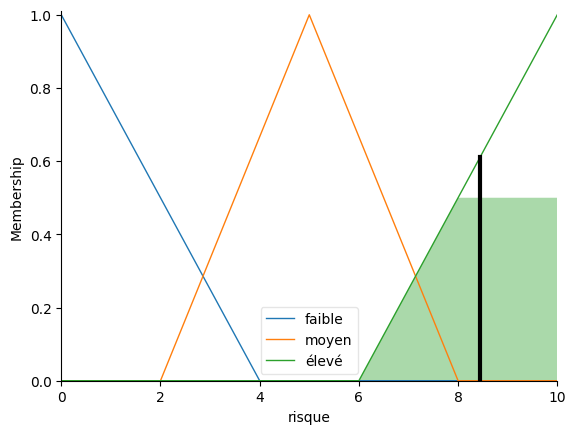

In [14]:
risque.view(sim=simulation)

**Machine Learning:**

In [16]:
np.random.seed(42)
n_samples = 2000
temp = np.random.uniform(0, 100, n_samples)
vib = np.random.uniform(0, 10, n_samples)
age = np.random.uniform(0, 20, n_samples)

In [17]:
risque_v = []
for t, v, a in zip(temp, vib, age):
    simulation.input['température'] = t
    simulation.input['vibration'] = v
    simulation.input['âge'] = a
    try:
        simulation.compute()
        risque_v.append(simulation.output['risque'])
    except:
        risque_v.append(np.nan)

In [22]:
data = pd.DataFrame({
    'température': temp,
    'vibration': vib,
    'âge': age,
    'risque': risque_v
})

In [23]:
data.head()

,température,vibration,âge,risque
0,37.454012,2.617057,11.439918,5.000000
1,95.071431,2.469788,16.108647,7.566452
2,73.199394,9.062546,15.203219,8.607336
3,59.865848,2.495462,3.077998,NaN
4,15.601864,2.719497,2.984989,1.700209


In [25]:
data=data.dropna()

In [26]:
X = data[['température', 'vibration', 'âge']]
y = data['risque']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

In [29]:
mae

np.float64(0.1021907636578244)

Exemple De Prediction

In [ ]:
#Le meme exemple qu'on a utilise pour la logique floue
ex = pd.DataFrame({'température':[80], 'vibration':[6], 'âge':[10]})
predicted_risque = model.predict(ex)[0]
print(predicted_risque)

8.44399211487456


**Interprétation et Analyse:**

On Remarque que les deux methodes ont presque le meme Resultat pour cette exemple , mais si on essaye  avec des valeurs proches des frontières le ML produit des valeurs  différentes du système flou : 

In [ ]:
ex1 = pd.DataFrame({'température':[60], 'vibration':[6], 'âge':[6]})
predicted_risque = model.predict(ex)[0]
print(predicted_risque)

5.243130148826011


In [34]:
simulation.input['température'] = 60
simulation.input['vibration'] = 6
simulation.input['âge'] = 6

simulation.compute()
print(simulation.output['risque'])

5.000000000000001


D'ou Les deux approches donnent des résultats très proches sur l’ensemble global, ce qui montre que le modèle ML a bien appris le comportement du système flou. mais, près des zones de transition entre les catégories  le modèle ML présente des écarts. car : 


la logique floue applique des règles définies à l’avance , tandis que le modèle ML fait une approximation basée sur les données qu’il a apprises